# Import and Exploratory Data Analysis on Openolli dataset

The data has already been downloaded using another script.
Now we would like to import the data and start a first analysis.

First of all, start by loading all the relevant packages:

In [1]:
# Loading packages

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

Because the dataset is quite big and can be difficult for your computer's memory to handle, you can divide the data in each csv-file into separate chunks and load them into your dataframe. We will also load only selected columns into the dataframe in order to speed up the process and to keep the dataframe as small as possible.

Import the data from the csv-files by looping over the range of months (note that the data is only available for the months February to December):

In [2]:
# load data

chunksize = 10**5
df = pd.DataFrame()
#filename = "2018_08.csv"
#df = pd.read_csv(filename)
for i in range(2,12):
    filename = "2018_"+"%02d" % i +".csv"
    for chunk in (pd.read_csv(filename, chunksize=chunksize, index_col=False, usecols=["last_seen", "longitude", "latitude", "speed", "doors"])):
        df = pd.concat([df, chunk], ignore_index=True)

With the data loaded into a dataframe, we can now start with an initial exploration of our data using the standard commands to describe our data:

In [3]:
print(df.head())
print(df.info())
print(df.describe())
print(df.columns)
print(df.shape)

    latitude  longitude  speed  doors                last_seen
0  52.482163  13.357212    0.0  False  2018-02-13 14:25:08 UTC
1  52.482163  13.357212    0.0  False  2018-02-13 14:25:08 UTC
2  52.482163  13.357212    0.0  False  2018-02-13 14:25:09 UTC
3  52.482163  13.357212    0.0  False  2018-02-13 14:25:09 UTC
4  52.482163  13.357212    0.0  False  2018-02-13 14:25:10 UTC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13384957 entries, 0 to 13384956
Data columns (total 5 columns):
latitude     float64
longitude    float64
speed        float64
doors        bool
last_seen    object
dtypes: bool(1), float64(3), object(1)
memory usage: 421.2+ MB
None
           latitude     longitude         speed
count  1.338496e+07  1.338496e+07  1.338496e+07
mean   5.248213e+01  1.335716e+01  2.550552e-02
std    1.446069e-02  1.940082e-02  2.953410e-01
min    4.353986e+01  1.359923e+00 -5.251053e+00
25%    5.248217e+01  1.335722e+01  0.000000e+00
50%    5.248217e+01  1.335722e+01  0.000000e+00
75%

The commands give us the following useful information:

- The DataFrame consists of roughly 13 mio rows, which already rises our attention. On the download page the step size of the timesteps is  described in seconds which the data also shows. Also the return of the .head() command shows that although there are different ids for each observation, the timestamps are doubled and sometimes even tripled. This should be dealt with in the following.
- We now have 5 different rows which are named:
        latitude
        longitude
        speed
        doors
        last_seen
- The minimum value of the 'latitude'-column is 43.53986 and of the 'longitude'-column it is 1.359923, which deviates strongly from our 25%, 50% and 75% quantile and the standard deviation. This is a point which we should investigate in the following.
- The 'speed' do not reveal any significant outliers at first sight when looking at the min and max values.
- 'last_seen' contains timestamp which can be used as datetime-index after a little cleaning.

Having found out, that 'last_seen' is a timestamp, we would like to change the index column in order to obtain a proper time series. Therefore we slice the last signs of the column (i.e. " UTC") in order to make the column interpretable for pd.to_datetime.

In [4]:
df_date = df
# slice 'last_seen' column
df_date['last_seen'] = df_date['last_seen'].str[:-4]

# rename 'last_seen' to 'date' and define it as index
df_date = df_date.rename(columns={'last_seen': 'date'})
df_date['date'] = pd.to_datetime(df_date['date'], utc=True)
df_date = df_date.set_index('date')

We now have a time series, which is also shown when calling

In [5]:
print(df_date.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13384957 entries, 2018-02-13 14:25:08+00:00 to 2018-11-30 13:42:20+00:00
Data columns (total 4 columns):
latitude     float64
longitude    float64
speed        float64
doors        bool
dtypes: bool(1), float64(3)
memory usage: 421.2 MB
None


Let us now deal with the multiple entries per second by resampling the DataFrame by using 'resample'. Depending on the type of data, a different method for resampling is chosen.

In [15]:
# Resampling using different methods depending on column type
df_date = df_date.resample('s').agg({'latitude' : np.mean, 'longitude' : np.mean, 'speed': np.mean ,'doors': 'any'})        
print(df_date.head())

                            latitude  speed  doors  longitude
date                                                         
2018-02-13 14:25:08+00:00  52.482163    0.0  False  13.357212
2018-02-13 14:25:09+00:00  52.482163    0.0  False  13.357212
2018-02-13 14:25:10+00:00  52.482163    0.0  False  13.357212
2018-02-13 14:25:11+00:00  52.482163    0.0  False  13.357212
2018-02-13 14:25:12+00:00  52.482163    0.0  False  13.357212


In [16]:
print(df_date.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25053433 entries, 2018-02-13 14:25:08+00:00 to 2018-11-30 13:42:20+00:00
Freq: S
Data columns (total 4 columns):
latitude     float64
speed        float64
doors        bool
longitude    float64
dtypes: bool(1), float64(3)
memory usage: 788.5 MB
None


# Fill missing values


Fill the missing values by using linear interpolation.

In [8]:
interpolated = df_date.loc[:,['latitude', 'longitude', 'doors']].interpolate(method='linear')
print(interpolated.head(32))

                            latitude  longitude  doors
date                                                  
2018-02-13 14:25:08+00:00  52.482163  13.357212  False
2018-02-13 14:25:09+00:00  52.482163  13.357212  False
2018-02-13 14:25:10+00:00  52.482163  13.357212  False
2018-02-13 14:25:11+00:00  52.482163  13.357212  False
2018-02-13 14:25:12+00:00  52.482163  13.357212  False
2018-02-13 14:25:13+00:00  52.482163  13.357212  False
2018-02-13 14:25:14+00:00  52.482163  13.357212  False
2018-02-13 14:25:15+00:00  52.482163  13.357212  False
2018-02-13 14:25:16+00:00  52.482163  13.357212  False
2018-02-13 14:25:17+00:00  52.482163  13.357212  False
2018-02-13 14:25:18+00:00  52.482163  13.357212  False
2018-02-13 14:25:19+00:00  52.482163  13.357212  False
2018-02-13 14:25:20+00:00  52.482163  13.357212  False
2018-02-13 14:25:21+00:00  52.482163  13.357212  False
2018-02-13 14:25:22+00:00  52.482163  13.357212  False
2018-02-13 14:25:23+00:00  52.482163  13.357212  False
2018-02-13

# Geodata Analysis

Now that we have a cleaned dataset, let us analyse where Openolli opened its doors during the monitored time.

But first, we can have a closer look on the complete time series. Using 'describe', we can see that both the latitude and longitude columns have a minimum that looks like an outlier when compared to the 25% and 75% quantile. Before we declare this as an outlier, let us dig a little deeper into the details. 

By boolean filtering, we can find the dates in the time series, for which the latitude and longitude fulfill these values. Interestingly, both minima occur together. 

Searching these coordinates in a map shows that the values show a location in Tolouse, France. Since the shuttle bus has been produced there, it might be possible, that it has been there for maintenance or some other reason. The values can therefore be explained and not really be considered as an oulier. We will therefore keep the values for now and not alter them in any way. We will later see whether it complicates our analysis or not.

           latitude     longitude
count  2.505343e+07  2.505343e+07
mean   5.247981e+01  1.335413e+01
std    1.175072e-01  1.576503e-01
min    4.353986e+01  1.359923e+00
25%    5.248209e+01  1.335719e+01
50%    5.248215e+01  1.335722e+01
75%    5.248217e+01  1.335733e+01
max    5.248322e+01  1.335794e+01
                            latitude  longitude  doors
date                                                  
2018-03-13 11:09:17+00:00  43.539858   1.359923  False
2018-03-13 11:09:18+00:00  43.539858   1.359923  False
2018-03-13 11:09:19+00:00  43.539858   1.359923  False
2018-03-13 11:09:20+00:00  43.539858   1.359923  False
2018-03-13 11:09:21+00:00  43.539858   1.359923  False
2018-03-13 11:09:22+00:00  43.539858   1.359923  False


/home/kteuber/.local/lib/python2.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


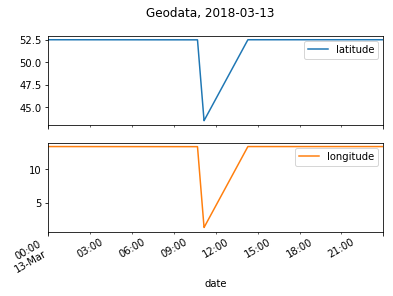

In [18]:
print(interpolated.describe())
print(interpolated.loc[interpolated['latitude'] == interpolated['latitude'].min()])
interpolated.loc['2018-03-13'].plot(subplots=True)
plt.suptitle('Geodata, 2018-03-13')
plt.show()

Only six entries are concerned by the minimum values and the doors were not open during this period of time.

In [19]:
print(interpolated.loc[interpolated['longitude'] == interpolated['longitude'].min()].info())

print(interpolated.loc[interpolated['longitude'] == interpolated['longitude'].min()])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2018-03-13 11:09:17+00:00 to 2018-03-13 11:09:22+00:00
Freq: S
Data columns (total 3 columns):
latitude     6 non-null float64
longitude    6 non-null float64
doors        6 non-null bool
dtypes: bool(1), float64(2)
memory usage: 150.0 bytes
None
                            latitude  longitude  doors
date                                                  
2018-03-13 11:09:17+00:00  43.539858   1.359923  False
2018-03-13 11:09:18+00:00  43.539858   1.359923  False
2018-03-13 11:09:19+00:00  43.539858   1.359923  False
2018-03-13 11:09:20+00:00  43.539858   1.359923  False
2018-03-13 11:09:21+00:00  43.539858   1.359923  False
2018-03-13 11:09:22+00:00  43.539858   1.359923  False


Now let us see the locations in which the doors were opened. We perform Boolean filtering in order to create a new DataFrame 'df_doorsopen' which now contains all the observations in the time series for which doors=True.

We can then drop the 'doors' column from the new 'df_doorsopen'-DataFrame, since it only contains the value True.

In [20]:
df_doorsopen=interpolated.loc[interpolated['doors']== True]
print(df_doorsopen.head())
print(df_doorsopen.describe())

df_doorsopen.drop(columns=['doors'])


                            latitude  longitude  doors
date                                                  
2018-02-13 14:36:39+00:00  52.482163  13.357213   True
2018-02-13 14:36:40+00:00  52.482163  13.357213   True
2018-02-13 14:36:41+00:00  52.482163  13.357213   True
2018-02-13 14:36:42+00:00  52.482163  13.357213   True
2018-02-13 14:36:43+00:00  52.482163  13.357213   True
           latitude     longitude
count  1.122524e+06  1.122524e+06
mean   5.248217e+01  1.335722e+01
std    8.483354e-05  1.050260e-04
min    5.248121e+01  1.335490e+01
25%    5.248217e+01  1.335722e+01
50%    5.248217e+01  1.335722e+01
75%    5.248221e+01  1.335725e+01
max    5.248313e+01  1.335766e+01


,latitude,longitude
date,,
2018-02-13 14:36:39+00:00,52.482163,13.357213
2018-02-13 14:36:40+00:00,52.482163,13.357213
2018-02-13 14:36:41+00:00,52.482163,13.357213
2018-02-13 14:36:42+00:00,52.482163,13.357213
2018-02-13 14:36:43+00:00,52.482163,13.357213
2018-02-13 14:36:44+00:00,52.482163,13.357213
2018-02-13 14:36:45+00:00,52.482163,13.357213
2018-02-13 14:36:46+00:00,52.482163,13.357213
2018-02-13 14:36:47+00:00,52.482163,13.357213


We will now print a quick scatter plot to have a look at the positions of the coordinates and whether we can detext anything unusual.

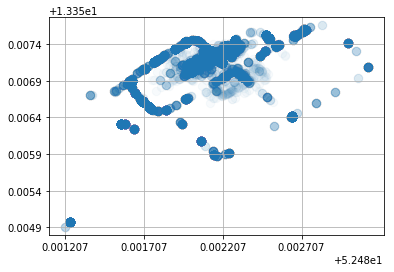

In [21]:
plt.scatter(df_doorsopen.loc[:,'latitude'], df_doorsopen.loc[:,'longitude'], s=70, alpha=0.03)
plt.xticks(np.arange(df_doorsopen['latitude'].min(), df_doorsopen['latitude'].max(), 5e-4))
plt.yticks(np.arange(1.335490e+01, 1.335766e+01, 5e-4))
plt.xlim(df_doorsopen['latitude'].min()-1e-4, df_doorsopen['latitude'].max()+1e-4)
plt.ylim(df_doorsopen['longitude'].min()-1e-4, df_doorsopen['longitude'].max()+1e-4)
plt.grid()
plt.show()

On first sight, the data does not show anything suspicious. We will export the DataFrame to a csv-file 'geodata.csv' which we will then visualize using Tableau Public.

In [ ]:
#df_doorsopen.loc[:,['latitude', 'longitude']].to_csv('geodata.csv')

# Time series analysis

Our time series data also offers the possibility of analysing the distance travelled by Openolli over different periods of time.
With the time series being in a frequent of seconds and the speed being stored in the unit meter per second, we can sum up the absolute values in the 'speed'-column using resampling in order to analyse the distance.

In a first step, let us have a look at the daily distance and plot it over the whole duration of the time series.

Using df_speed.describe() reveals that the maximum distance travelled in one day was 8857.04m (the minimum is 0m, so no movement at all). The mean distance travelled was 1205.78m per day. The distances appear to be in a reasonable order of magnitude and look plausible.

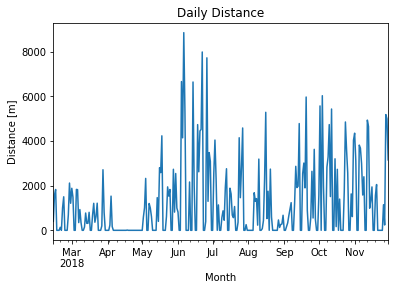

False
count     291.000000
mean     1205.776675
std      1702.147126
min         0.000000
25%         0.000000
50%       362.543640
75%      1885.754566
max      8857.035923
Name: speed, dtype: float64


In [24]:
# Resampling the speed column
df_speed = df_date['speed'].abs().resample('D').sum()

# Plotting
df_speed.plot()
plt.title('Daily Distance')
plt.ylabel('Distance [m]')
plt.xlabel('Month')
plt.show()

# Make sure that there are no NaNs
print(df_speed.isna().any())

# Show details
print(df_speed.describe())

We will now go a little more into detail and analyse how the daily distance varies over different weeks. In a first step, we add a column 'weekday' to the dataframe and use it as an index for a new DataFrame data_by_week.

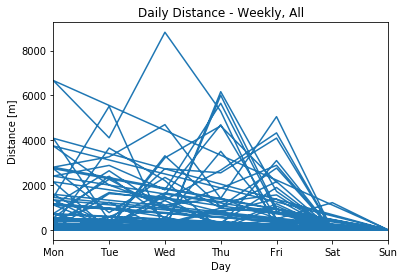

In [26]:
df_date['weekday'] = df_date.index.weekday
data_by_week = df_date.resample('D').agg({'speed': np.sum, 'weekday': np.mean}).set_index(['weekday']).unstack('day')
data_by_week['speed'].abs().plot().set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Daily Distance - Weekly, All')
plt.ylabel('Distance [m]')
plt.xlabel('Day')
plt.xlim(0,6)
plt.show()

Although the plot looks a little messy because it shows each week as a single line, we can derive a few insights:
- The longest distance of the whole observation period was travelled on a Wednesday, all the other Wednesdays recorded were much less busy. 
- There were quite a few Thursdays on which long distances were travelled. They were all in a range of approximately 6000m. 
- On weekends (Saturdays and Sundays), there was only little traffic. The maximum on a Saturday was about 1000m, on Sundays the shuttle was never in motion.

If we now have a look at the overall sum of the daily distance travelled for each weekday and the mean, we sharpen our statements:
Within the week, there appears to be a upward trend of traffic starting with an average on around 900m and reaches a peak on Thursday at around 1300m. In the last days of the week, the travelled distance then declined again until it goes down to 0m on Sundays.

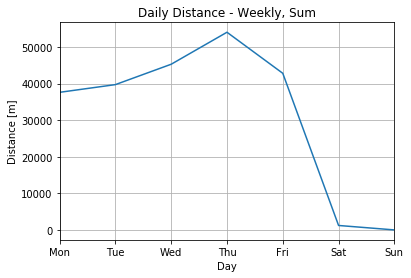

In [27]:
cum_sum_week= data_by_week['speed'].abs().groupby('weekday').sum()
cum_sum_week.plot(grid=True).set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Daily Distance - Weekly, Sum')
plt.ylabel('Distance [m]')
plt.xlabel('Day')
plt.xlim(0,6)
plt.show()

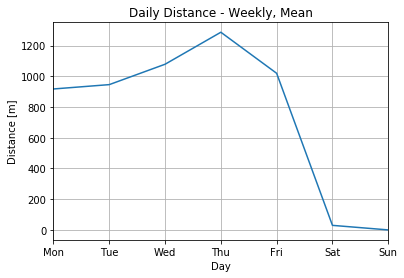

In [28]:
mean_week= data_by_week['speed'].abs().groupby('weekday').mean()
mean_week.plot(grid=True).set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Daily Distance - Weekly, Mean')
plt.ylabel('Distance [m]')
plt.xlabel('Day')
plt.xlim(0,6)
plt.show()

We will now perform the same steps we performed on the weekly data on a resampled DataFrame containing hourly data on a daily basis.
So let's start with the first plot containing the hourly data of each day.
This plot contains even more lines than the weekly plot since there are more days than weeks in our observation but again it helps us to draw some conclusions:
- The operating hours of Openolli were between 5am and 7pm. 
- 12am was the busiest time for the bus.


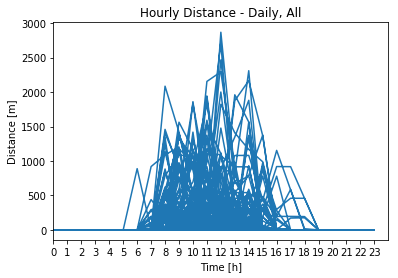

In [29]:
df_date['day'] = df_date.index.day
df_date['hour'] = df_date.index.hour
data_by_day = df_date.resample('h').agg({'latitude' : np.mean, 'longitude' : np.mean, 'speed': np.sum ,'day': np.mean,'hour': np.mean}).set_index(['hour']).unstack('day')
data_by_day['speed'].abs().plot()
plt.xlim(0,24)
plt.xticks(np.arange(0, 24, 1))
plt.title('Hourly Distance - Daily, All')
plt.ylabel('Distance [m]')
plt.xlabel('Time [h]')

plt.show()

The plot of the mean distance travelled per hour confirms what we saw in the previous plot: The bus operated between 5am and 7pm. The main operating hours were between 8am and 3pm with mean hourly distances between approximately 40m and 90m per hour.

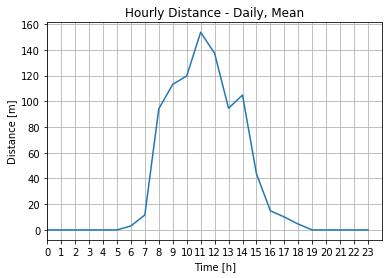

In [31]:
mean_day= data_by_day['speed'].abs().groupby('hour').mean()
mean_day.plot(grid=True)
plt.xlim(0,24)
plt.xticks(np.arange(0, 24, 1))
plt.title('Hourly Distance - Daily, Mean')
plt.ylabel('Distance [m]')
plt.xlabel('Time [h]')
plt.show()

These distances derived here do not seem very far but we have to keep in mind that the shuttle bus mainly operated on the property where the innovation hub was located (see geodata analysis).
We can also see that the bus operated between common office hours and mostly during lunch time. This observation makes sense if you think about the fact that in an area with many offices most people commute during lunch time.

What the data also shows is that the shuttle bus has not been used on weekends or at night when there is in general a low availability of public transport. Ideas like using the shuttle for late night transport (https://openolli.innoz.space/hackathon/olli_nightshift) could be a way to improve the usage of such a shuttle bus.